In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
import torch.optim as optim
from PIL import Image, ImageEnhance
import cv2

In [2]:
def hist_eq(img_out) :
    img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
    img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
    img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])
    return img_out

In [3]:
class CenterCrop224(object):
    
    def __init__(self, output_size=224):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        img = np.array(image)
        h, w = img.shape[:2]
        sz = self.output_size
        
        if h == w: 
            return cv2.resize(img, (sz, sz), cv2.INTER_AREA)
        
        elif h > w:
            scaling_factor = sz / w
            x_shape = sz
            y_shape = int(h * scaling_factor)
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((y_shape - sz) / 2)
            img_reshaped = img_reshaped[offset:offset + sz, :, :]
            
        else :
            scaling_factor = sz / h
            x_shape = int(w * scaling_factor) 
            y_shape = sz
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((x_shape - sz) / 2)
            img_reshaped = img_reshaped[:, offset:offset+sz, :]
        return img_reshaped
cc224 = CenterCrop224()

In [4]:
transform = transforms.Compose([CenterCrop224(), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

# transform = transforms.Compose([VGG16_Weights.IMAGENET1K_V1.transforms])
# transform = VGG16_Weights.IMAGENET1K_V1.transforms

In [5]:
img = cv2.cvtColor(cv2.imread('puffer.JPEG'), cv2.COLOR_BGR2RGB)

img = transform(img)
# img = Image.open('puffer.JPEG')
# print(img.size)

# img = img.transform([244], transforms.InterpolationMode.BILINEAR)

In [6]:
image = transforms.ToPILImage()(img).convert("RGB")

In [7]:
import json
f_labels = open('imagenet_class_index.json', 'r')
labels = json.load(f_labels)
f_labels.close()

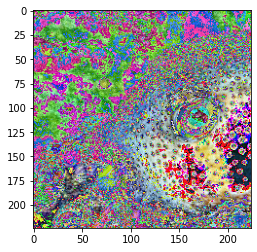

In [8]:
plt.imshow(image)

### Conv Network

In [9]:
class ConvVgg16(nn.Module):
    def __init__(self, save_switches=False):
        super().__init__()
        
        self.save_switches = save_switches
        # indices of Conv2d layres
        self.modules_no = []
        
        # self.features = vgg16(pretrained=True).features
        self.features = vgg16(weights='DEFAULT').features
        
        for i, feature in enumerate(self.features) :
            if isinstance(feature, nn.MaxPool2d):
                self.features[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices = True)
            
            elif isinstance(feature, nn.Conv2d):
                self.modules_no.append(i)
            
        # self.avgpool = vgg16(pretrained=True).avgpool
        self.avgpool = vgg16(weights='DEFAULT').avgpool
        
        # self.classifier = vgg16(pretrained=True).classifier
        self.classifier = vgg16(weights='DEFAULT').classifier
                        
        
    def forward (self, x) :
        conv_results = {}
        maxpool_indices = {}
        for i, layer in enumerate(self.features):
            
            if isinstance(layer, nn.MaxPool2d):
                x, index = layer(x)
                maxpool_indices[i] = index
                
            else :
                x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                conv_results[i] = x
            
        
            
        x = self.avgpool(x)
        x = x.flatten()
        x = self.classifier(x)
        
        
        if not self.save_switches :
            return x    
            
        return x, conv_results, maxpool_indices
    

### Deconv

In [10]:
class ConvDeconvVGG16(nn.Module) :
    def __init__(self) :
        
        super().__init__()
        
        
        self.conv_model = ConvVgg16(save_switches=True)

        
        self.conv_indices = []
        self.maxpool_indices = []
        
        module_list = []
        
        for i, layer in enumerate(self.conv_model.features) :
            if isinstance(layer, nn.Conv2d):
                module_list.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding))
                module_list[i].weight.data = layer.weight.data
                self.conv_indices.append(i)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_list.append(nn.MaxUnpool2d(kernel_size=2, stride=2))
                self.maxpool_indices.append(i)
                
            elif isinstance(layer, nn.ReLU):
                module_list.append(nn.ReLU(inplace=True))
        
        module_list.reverse()
        self.module_list = nn.ModuleList(module_list)
     
    
    def __zero_activation(self, y, k) :
        if k == 'channel' :
            y_sum = y.sum(axis=1).sum(axis=1)
            y_argmax = y_sum.argmax().item()
            y_zerod = torch.zeros_like(y)
            y_zerod[y_argmax, :, :] = y[y_argmax, :, :]
            return y_zerod
        
        elif k == 'pixel' :
            y_idx = y.argmax().item()
            y_max = y.max().item()
            y_zerod = torch.zeros_like(y).flatten()
            y_zerod[y_idx] = y_max
            return y_zerod.reshape(y.shape)
    
        
    def forward(self, x, layer_ix, zero_type='channel') :
        
        conv_pred_vector, conv_results, switches  = self.conv_model(x)
        conv_pred = conv_pred_vector.argmax().item()
        
        y = conv_results[self.conv_indices[layer_ix]]
        y = self.__zero_activation(y, zero_type)

        
        
        for i, layer in enumerate(self.module_list[(30 - self.conv_indices[layer_ix]):]) :
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, switches[self.conv_indices[layer_ix] - i])
            else :
                y = layer(y)
                
        ret = {"pred_prob" : conv_pred_vector, "pred" : conv_pred, "conv_results": conv_results, "deconv" : y}
        return ret
        
        

In [11]:
model = ConvDeconvVGG16()

ConvDeconvVGG16(
  (conv_model): ConvVgg16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace

In [12]:
out = model(img, 7)
print(f"Class : {out['pred']}: {labels[str(out['pred'])][1]}")

Class : 397: puffer


In [13]:
img_out = out['deconv'].permute(1, 2, 0).detach().cpu().numpy()

In [14]:
img_out = (img_out - img_out.min()) / (img_out.max() - img_out.min())
# img_out = (img_out * 255).astype(np.uint8)

In [15]:
# # Histogram equalization on img_out
# img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
# img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
# img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])

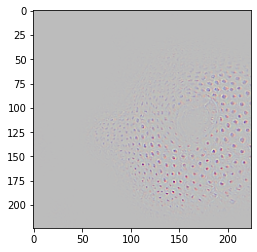

In [16]:
plt.imshow(img_out)

#### Occlusion

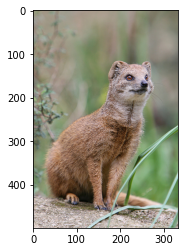

In [17]:
model = ConvDeconvVGG16()

img = cv2.cvtColor(cv2.imread('mong.JPEG'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [18]:
def generate_class_map(img, label, occ_sz, step) :
    
    dim = ((224 - occ_sz) // (step - 1)) + 1
    
    class_map = np.zeros(shape=(dim, dim))
    prob_map = np.zeros(shape=(dim , dim))
    
    for i in range(0, 244 - occ_sz, step) :
        for j in range(0, 244 - occ_sz, step) :
            
            img_cpy = transform(img.copy())
            img_cpy[:, i:i+occ_sz, j:j+occ_sz] = 0.5
            
            res = model(img_cpy, 1, zero_type='pixel')
            
            pred = res['pred']
            oc_label = res['pred_prob'][label].item()
            
            class_map[i // step, j // step] = pred
            prob_map[i // step, j // step] = oc_label
    
    return class_map, prob_map

In [19]:
class_map, prob_map = generate_class_map(img, 298, 55, 10)

In [20]:
img = cv2.cvtColor(cv2.imread('mong.JPEG'), cv2.COLOR_BGR2RGB)
occ_sz = 50
img_cpy = transform(img)
res = model(img_cpy, 9, zero_type='pixel')
img_out_og = res['deconv'].permute(1, 2, 0).detach().cpu().numpy()
img_out_og = (img_out_og - img_out_og.min()) / (img_out_og.max() - img_out_og.min())
img_out_og = (img_out_og * 255).astype(np.uint8)

In [21]:
img_cpy = transform(img.copy())
img_cpy[:, 20:20 + occ_sz, 130:130 + occ_sz] = 0.5
res = model(img_cpy, 9, zero_type='pixel')
img_out_occ = res['deconv'].permute(1, 2, 0).detach().cpu().numpy()
img_out_occ = (img_out_occ - img_out_occ.min()) / (img_out_occ.max() - img_out_occ.min())
img_out_occ = (img_out_occ * 255).astype(np.uint8)


Text(0.5, 1.0, 'Class Map')

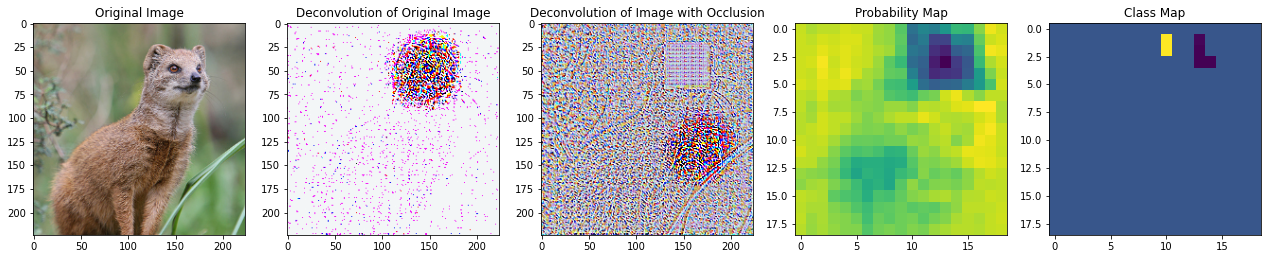

In [23]:
fig, ax = plt.subplots(1, 5, figsize=(22, 18))
fig.set_facecolor('white')

ax[0].imshow(cc224(img))
ax[0].set_title('Original Image')

ax[1].imshow(hist_eq(img_out_og))
ax[1].set_title('Deconvolution of Original Image')

ax[2].imshow(hist_eq(img_out_occ))
ax[2].set_title('Deconvolution of Image with Occlusion')

ax[3].imshow(prob_map)
ax[3].set_title('Probability Map')

ax[4].imshow(class_map)
ax[4].set_title('Class Map')